## Lung Segmentation using watershed algorithm
## Data Science Bowl 2017 competetion

In [1]:
# packages
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import glob
import os
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print '%s: %s' %(var,module.__version__)
    
# package version    
get_version('numpy','matplotlib','cv2','skimage')

numpy: 1.11.2
matplotlib: 1.5.1
cv2: 2.4.10
skimage: 0.12.3


## settings

In [2]:
# Some constants 
#INPUT_FOLDER = '../stage1/'
INPUT_FOLDER = '../sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
path2output='./output/data/'

### utils

In [3]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# Some of the starting Code is taken from ArnavJain, since it's more readable then my own
def generate_markers(image):
    H,W=image.shape
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    # pick top three regions
    nb_regions=3
    if len(areas) > nb_regions:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-nb_regions]:
                for coordinates in region.coords:                
                    marker_internal_labels[coordinates[0], coordinates[1]] = 0
    #marker_internal = marker_internal_labels > 0

    # remove regions near the border
    #deltas = [H-np.max(d.coords) for d in measure.regionprops(marker_internal_labels)]
    #deltas.sort()
    #nb_regions=2
    #if len(deltas) > nb_regions:
    #    for region in measure.regionprops(marker_internal_labels):
    #        delta=H-np.max(region.coords)
    #        if delta < deltas[-nb_regions]:
    #            for coordinates in region.coords:                
    #                marker_internal_labels[coordinates[0], coordinates[1]] = 0
    #marker_internal = marker_internal_labels > 0
    
    
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((H, W), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    marker_out=[marker_internal,marker_external,marker_watershed]
    return marker_out

def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    out=[segmented, lungfilter, outline, watershed, sobel_gradient,\
                     marker_internal, marker_external, marker_watershed]
    return out

def array_stats(X):
    X=np.asarray(X)
    print 'array shape: ',X.shape, X.dtype
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print 'min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X))
    
print ('utils!')

utils!


array shape:  (20,) int64
min: 110, max: 435, avg: 1.8e+02, std:73.3
Total patients 20 Total DCM files 3604


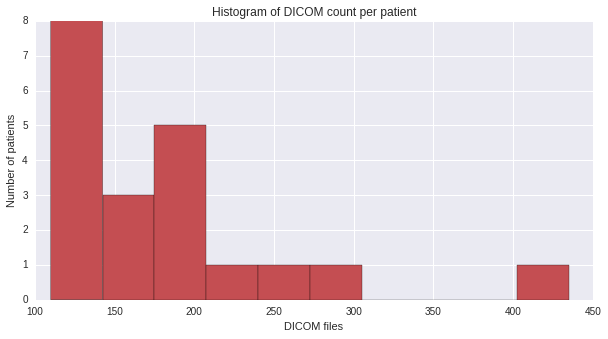

In [4]:
nb_dicoms=[]
for d in patients:
    #print("Patient '{}' has {} scans".format(d, len(os.listdir(path2data + d))))
    nb_dicoms.append(len(os.listdir(INPUT_FOLDER + d)))

array_stats(nb_dicoms)    
print('Total patients {} Total DCM files {}'.format(len(patients), len(glob.glob(INPUT_FOLDER+'*/*.dcm'))))

p = sns.color_palette()
plt.figure(figsize=((10,5)))
plt.hist(nb_dicoms, color=p[2])
plt.ylabel('Number of patients')
plt.xlabel('DICOM files')
plt.title('Histogram of DICOM count per patient')
plt.show()

### sample image

elapsed time: 22 msec


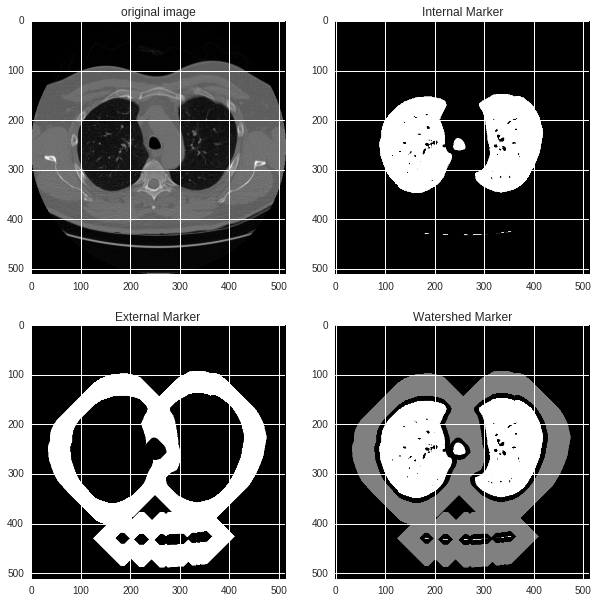

In [5]:
patient=9
slicenm=60

scans = load_scan(INPUT_FOLDER + patients[patient])
images = get_pixels_hu(scans)


#Show some example markers from the middle        
import time
start_time=time.time()
markers = generate_markers(images[65])

elapsed_time=(time.time()-start_time)
print ('elapsed time: %.2d msec' %(elapsed_time*1000))

plt.figure(figsize=(10,10))

plt.subplot(221)
plt.imshow(images[slicenm], cmap='gray')
plt.title("original image")

plt.subplot(222)
plt.imshow(markers[0], cmap='gray')
plt.title("Internal Marker")

plt.subplot(223)
plt.imshow(markers[1], cmap='gray')
plt.title("External Marker")

plt.subplot(224)
plt.imshow(markers[2], cmap='gray',)
plt.title("Watershed Marker")
plt.show()

### sample segementation

slice num: 0


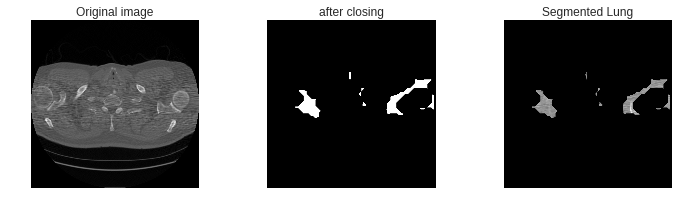

slice num: 5


KeyboardInterrupt: 

In [18]:
# perfrom segmentatio
start_time=time.time()
for slice_nm in range(0,len(images),5):
    print ('slice num: %s' %slice_nm)
    masks=seperate_lungs(images[slice_nm])
    
    plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(images[slice_nm], cmap='gray')
    plt.title("Original image")
    
    plt.subplot(132)
    plt.axis('off')
    plt.imshow(masks[1], cmap='gray')
    plt.title("after closing")

    plt.subplot(133)
    plt.axis('off')
    plt.imshow(masks[0], cmap='gray')
    plt.title("Segmented Lung")
    plt.show()

elapsed_time=(time.time()-start_time)    
print ('elapsed time: %.1d sec' %(elapsed_time))

In [31]:
# perfrom segmentatio
print 'wait ...'
start_time=time.time()
Y1=np.zeros_like(images,'uint8')
for slice_nm in range(0,len(images)):
    print ('slice num: %s' %slice_nm)
    masks=seperate_lungs(images[slice_nm])
    Y1[slice_nm]=masks[1]

elapsed_time=(time.time()-start_time)    
print ('elapsed time: %.1d sec' %(elapsed_time))

wait ...
slice num: 0
slice num: 1
slice num: 2
slice num: 3
slice num: 4
slice num: 5


KeyboardInterrupt: 

(244, 512, 512)
array shape:  (244, 512, 512) uint8
min: 0, max: 1, avg: 0.000339, std:0.0184


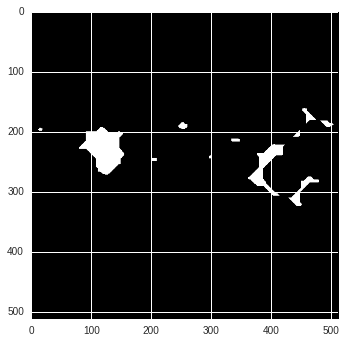

In [30]:
print Y1.shape
array_stats(Y1)
plt.imshow(Y1[5],cmap='gray')